In [655]:
import process_data
from process_data import get_dfs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit  
from scipy.special import voigt_profile
from scipy.ndimage import gaussian_filter1d
import pickle
import os
import importlib
importlib.reload(process_data)

<module 'process_data' from '/Users/xnimir/Desktop/Sn exp 2024/process_data.py'>

In [656]:
def gaussian(x, A, mu, sigma, B):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + B

In [657]:
def standard_lorentzian(x, amplitude, center, width, offset):
    return amplitude * width**2 / ((x - center)**2 + width**2) + offset

In [658]:
def super_lorentzian(x, amplitude, center, width, power, offset):
    # Generalized Lorentzian with adjustable power for wider wings
    return amplitude * width**power / ((x - center)**power + width**power) + offset

In [659]:
def voigt(x, amplitude, center, g_width, l_width, offset):
    basic_voigt = amplitude * voigt_profile(x - center, g_width, l_width)
    return basic_voigt + offset

In [660]:
def modified_voigt(x, amplitude, center, g_width, l_width, offset, slope, modification_factor, transition_point):
    penalty = 1e6 * (1 - np.exp(-g_width**2 / (1e-4))) if g_width < 1e-4 or l_width < 1e-4 else 0
    basic_voigt = amplitude * voigt_profile(x - center, g_width, l_width)
    wing_enhancement = modification_factor * amplitude * (g_width**2 / ((x - center)**2 + g_width**2))**0.5
    baseline = offset + slope * np.maximum(0, x - transition_point)
    return basic_voigt + wing_enhancement + baseline + penalty
   

In [661]:
def gaus_fitting(x,y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    initial_guess = [np.max(y), x[np.argmax(y)], np.std(x), 0]
    bounds = ([0, 0, 0, 0], [np.inf, np.max(x), np.inf, np.inf])
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, bounds=bounds, sigma=np.sqrt(y), absolute_sigma=True)
    y_fit = gaussian(x_fit, *popt)

    fwhm = 2.355 * popt[2] * 1E6
    fit_errors_g = np.sqrt(np.diag(pcov))
    mu_error = fit_errors_g[1]

    return x_fit, y_fit, popt, pcov, fwhm

In [662]:
def focus_on_peak(x, y, fit_width):
    # Find the x-value of the peak (maximum y-value)
    peak_index = np.argmax(y)
    peak_x = x[peak_index]
    
    # Define the fitting window around the peak
    x_min = peak_x - fit_width
    x_max = peak_x + fit_width
    
    # Filter x and y values within the fitting window
    mask = (x >= x_min) & (x <= x_max)
    x_subset = x[mask]
    y_subset = y[mask]
    
    return x_subset, y_subset

In [663]:
def voigt_fitting(file, x, y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)
    
    amplitude = np.max(y)
    center = x[np.argmax(y)]

    # half_max = amplitude / 2
    # indices_above_half_max = np.where(y >= half_max)[0]
    # if len(indices_above_half_max) > 1:
    #     fwhm = x[indices_above_half_max[-1]] - x[indices_above_half_max[0]]
    #     g_width = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to standard deviation
    # else:
    #     g_width = (x[-1] - x[0]) / 10  # Fallback: estimate width as a fraction of x range
    g_width = 200E-6 / (2 * np.sqrt(2 * np.log(2)))
    l_width = g_width / 2  # Start with l_width smaller than g_width
    offset = np.min(y)

    weights = 1 / np.sqrt(y + 1)
    # weights = 1 / (np.sqrt(y + 1) + np.abs(x - center) * 100)


    # lower_bounds = [0, np.min(x), 0, 0, -np.inf, 0]  # Amplitude >= 0
    # upper_bounds = [np.inf, np.max(x), np.max(x) - np.min(x), np.max(x) - np.min(x), np.inf, 1]  # No tight upper bounds

    if any(substring in file for substring in ['Sn-114', 'Sn-122_', 'Sn-124_']):  # fixing weird shape
        # x, y = focus_on_peak(x, y, fit_width=0.0009)
        slope = 50000
        modification_factor = 0.1
        transition_point = 0.005
        popt, pcov = curve_fit(modified_voigt, x, y, 
                        p0=[amplitude, center, g_width, l_width, offset, slope, modification_factor, transition_point])
        y_fit = modified_voigt(x_fit, *popt)
     
    else:
        popt, pcov = curve_fit(voigt, x, y, 
                            p0=[amplitude, center, g_width, l_width, offset],
                            sigma = weights)
                            # bounds=(lower_bounds, upper_bounds))
        y_fit = voigt(x_fit, *popt)


    g_width_fit = popt[2]  # Extract Gaussian width from popt
    l_width_fit = popt[3]  # Extract Lorentzian width from popt
    fwhm = np.sqrt(g_width_fit**2 + l_width_fit**2) * 1E6

    return x_fit, y_fit, popt, pcov, fwhm

In [664]:
def get_scatter_plot(data_df, time_df, freq_df, file):
    x = data_df['Bin center']
    y = data_df['Count raw']
    # y_1 = gaussian_filter1d(data_df['Count raw'], sigma=2)
    # y = data_df['Total_count']
    # y_norm = data_df['Norm count']
    x_fit_g, y_fit_g, popt_g, pcov_g, fwhm_g = gaus_fitting(x, y)
    x_fit_v, y_fit_v, popt_v, pcov_v, fwhm_v = voigt_fitting(file, x, y)
    

    plt.figure()
    # plt.errorbar(x, y, yerr=np.sqrt(y), fmt='o', capsize=3)
    plt.scatter(x,y)
    # plt.plot(x_fit_g, y_fit_g, color='green', label = 'G')
    plt.plot(x_fit_v, y_fit_v, color='red', label = 'V')
    plt.title(f'{file}')
    plt.xlabel('frequency (THz)')
    plt.ylabel('binned counts')
    # plt.legend()

    # label_g = f'Gaussian: mu={popt_g[1]:.6f} THz\nfwhm={fwhm_g:.2f} MHz'
    # plt.text(0.95, 0.95, label_g, fontsize=10,
    #                     verticalalignment='top', horizontalalignment='right',
    #                     transform=plt.gca().transAxes) 
    
    label_v = f'mu={popt_v[1]:.6f} THz\nfwhm={fwhm_v:.2f} MHz'
    plt.text(0.95, 0.95, label_v, fontsize=10,
                        verticalalignment='top', horizontalalignment='right',
                        transform=plt.gca().transAxes) 
    plt.show()

    # plt.title('Frequency')
    # plt.scatter(freq_df['Bin center'], freq_df['Count raw'], color='red')
    # plt.show()
    # plt.title('Time')
    # plt.scatter(time_df['Bin center'], time_df['Count raw'])
    # plt.show()

    return popt_v[1]

In [665]:
def main(folder_path):
    peaks_120 = []
    peaks = []

    for filename, scaled_df, time_df, freq_df, isotope in get_dfs(folder_path):
        peak_freq = get_scatter_plot(scaled_df, time_df, freq_df, filename)

        if isotope == 120:
                peaks_120.append(peak_freq)
        else: 
            peaks.append((isotope, peak_freq))
    return peaks_120, peaks


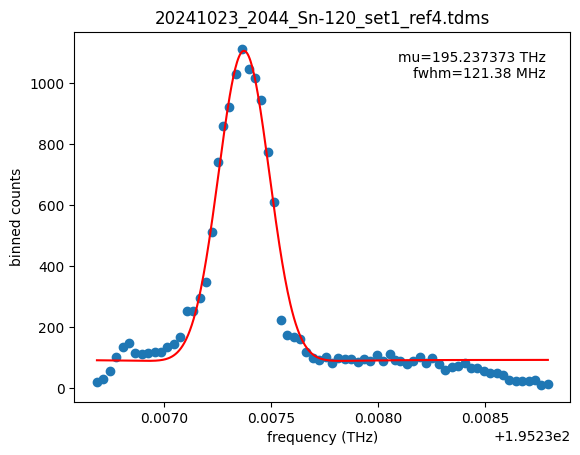

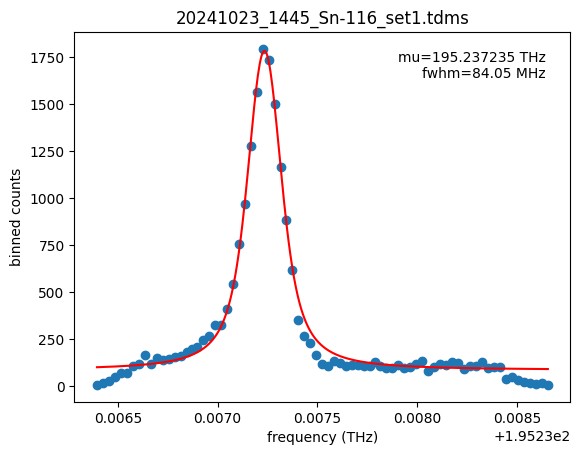

KeyboardInterrupt: 

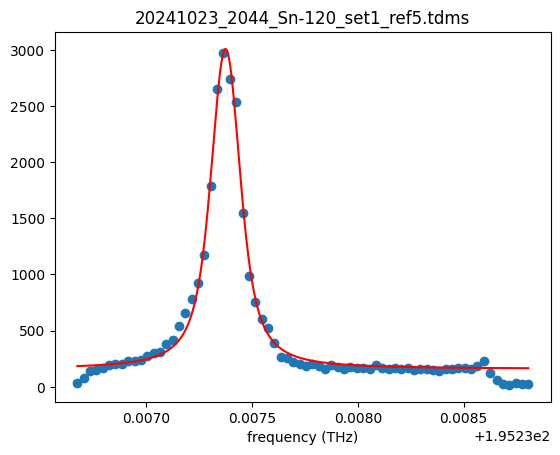

In [666]:
def single_set():
    folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set1/'
    main(folder_path)
single_set()

In [641]:
def multiple_sets():
    folder_base_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set'  
    results = {}
    sn120 = {}

    for set_number in range(1,11):  # iterated from n to n-1
        folder_path = f'{folder_base_path}{set_number}/'  
        
        peaks_120, peaks = main(folder_path)
        avg_120 = np.mean(peaks_120)
        stdev = np.std(peaks_120)

        sn120[set_number] = {
            'peaks_120': peaks_120,
            # 'fwhms_120': fwhms_120,
            'avg_120': avg_120,
            'stdev': stdev
        }

        isotopes_dict = {}  
        for isotope, peak_freq in peaks:
            if isotope not in isotopes_dict:
                isotopes_dict[isotope] = {
                    'peak_freq': [peak_freq]
                }
            else:
                isotopes_dict[isotope]['peak_freq'].append(peak_freq)
    
        results[set_number] = {
            'isotopes': list(isotopes_dict.keys()),  # List of isotopes (keys from isotopes_dict)
            'peaks': [item['peak_freq'] for item in isotopes_dict.values()]  # List of peak frequencies for each isotope
        }
        
    # isotope = 116
    # set_number = 10

    # isotope_index = results[set_number]['isotopes'].index(isotope)

    # peak_freqs = results[set_number]['peaks'][isotope_index]
    # print(peak_freqs)  

    # print(results)
    # print(sn120)
    with open('results.pkl', 'wb') as file:
        pickle.dump(results, file)

    with open('sn120.pkl', 'wb') as file:
        pickle.dump(sn120, file)

    # return results, sn120

In [642]:
# multiple_sets()

In [643]:
# prevents from running the analysis more than necessary and saves the results 
def get_pickled_data():
    with open('results.pkl', 'rb') as file:
        results = pickle.load(file)

    with open('sn120.pkl', 'rb') as file:
        sn120 = pickle.load(file)
    return results, sn120

In [644]:
results, sn120 = get_pickled_data()
print(results)
print(sn120)

{1: {'isotopes': [116, 118], 'peaks': [[np.float64(195.23723456592697)], [np.float64(195.23726171863447)]]}, 2: {'isotopes': [116, 122, 124, 118], 'peaks': [[np.float64(195.23730428080896)], [np.float64(195.2374104398296)], [np.float64(195.23745752785615)], [np.float64(195.23732534725283)]]}, 3: {'isotopes': [116, 124, 112, 118, 122], 'peaks': [[np.float64(195.23736870012883)], [np.float64(195.23748521382674)], [np.float64(195.2371952619868)], [np.float64(195.23737293519594)], [np.float64(195.2374794117812)]]}, 4: {'isotopes': [122, 114, 118, 116, 124], 'peaks': [[np.float64(195.2373477139442)], [np.float64(195.23728036401423)], [np.float64(195.23730887166474)], [np.float64(195.23725856035452)], [np.float64(195.23744349484576), np.float64(195.2374398612941)]]}, 5: {'isotopes': [124, 122, 118, 116], 'peaks': [[np.float64(195.23747086349653)], [np.float64(195.23745164037993)], [np.float64(195.23738568868146)], [np.float64(195.23733712287367)]]}, 6: {'isotopes': [118, 124, 116, 122], 'pea

(np.float64(195.23737925625707),
 np.float64(3.2879038104781335e-06),
 '195.237379(3)')

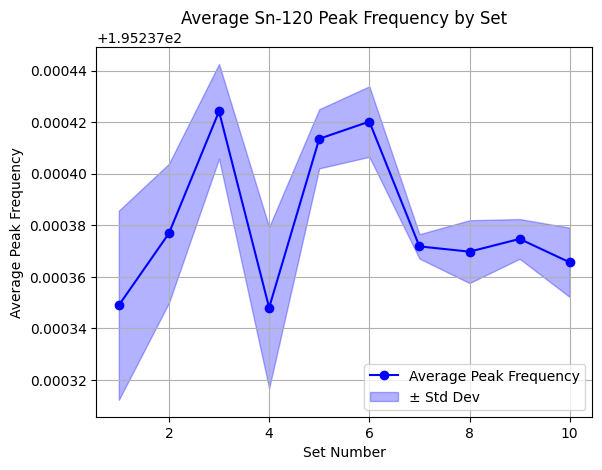

In [679]:
set_numbers = list(sn120.keys())
avg_120_values = [sn120[set_number]['avg_120'] for set_number in set_numbers]
stdev_values = [sn120[set_number]['stdev'] for set_number in set_numbers]
peaks_120_values = [sn120[set_number]['peaks_120'] for set_number in set_numbers]
stdev_vals = np.array([sn120[set_number]['stdev'] for set_number in sn120.keys()])


plt.plot(set_numbers, avg_120_values, label='Average Peak Frequency', color='b', marker='o')
plt.fill_between(set_numbers, np.array(avg_120_values) - np.array(stdev_values), np.array(avg_120_values) + np.array(stdev_values), alpha=0.3, color='b', label='± Std Dev')
plt.xlabel('Set Number')
plt.ylabel('Average Peak Frequency')
plt.title('Average Sn-120 Peak Frequency by Set')
plt.grid(True)
plt.legend()

weights = 1 / (stdev_vals**2)
weighted_average = np.sum(weights * avg_120_values) / np.sum(weights)
combined_uncertainty = np.sqrt(1 / np.sum(weights))
result = f"{weighted_average:.6f}({int(combined_uncertainty * 1e6)})"
weighted_average, combined_uncertainty, result


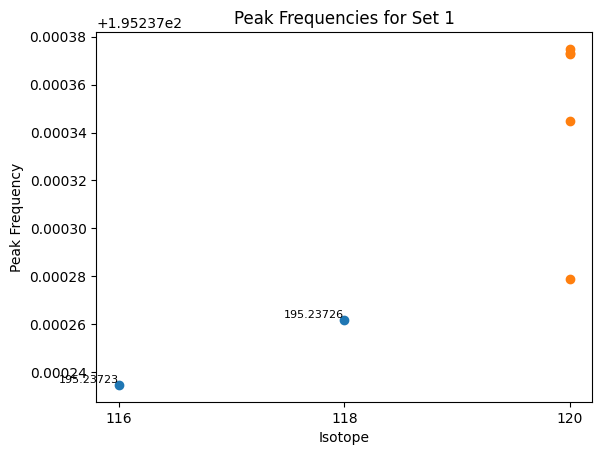

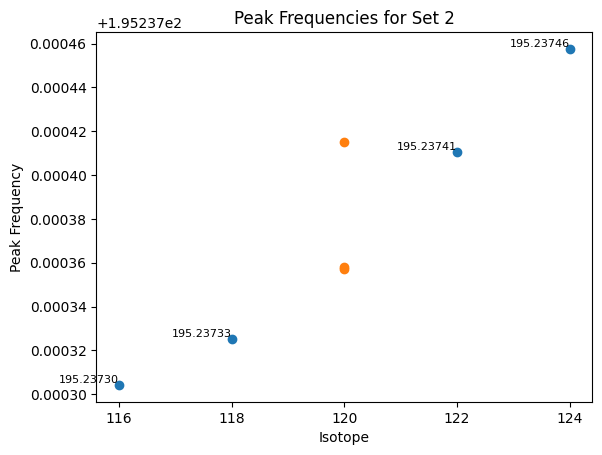

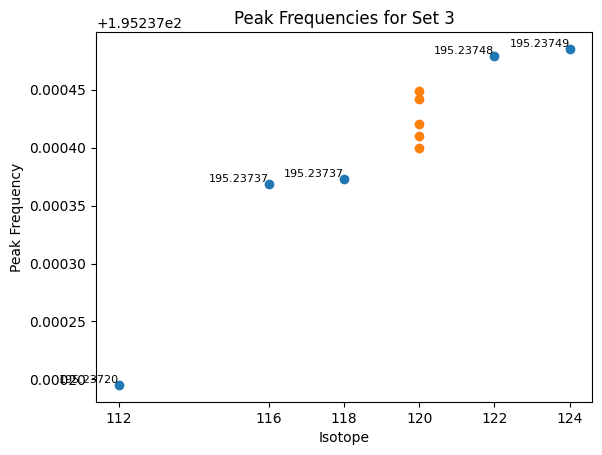

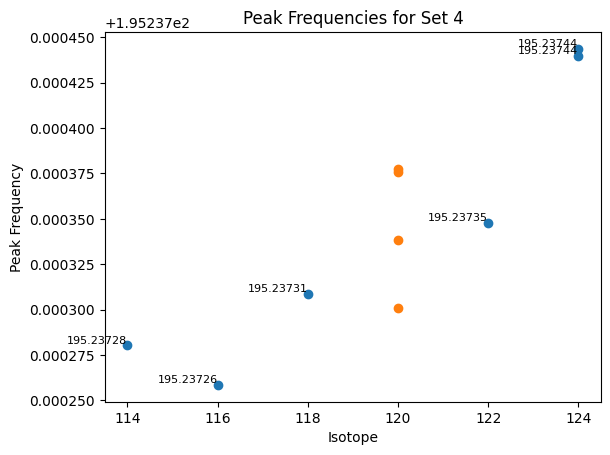

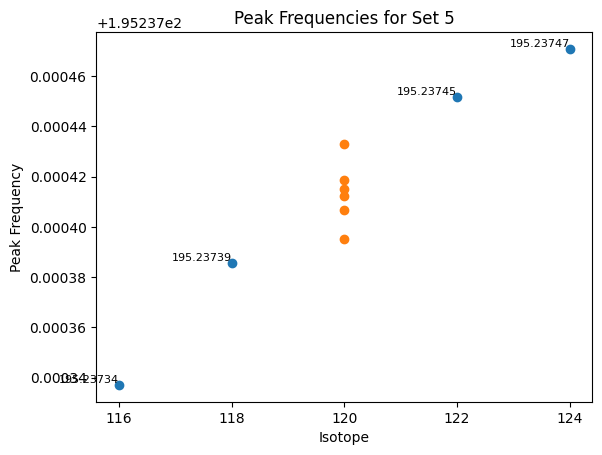

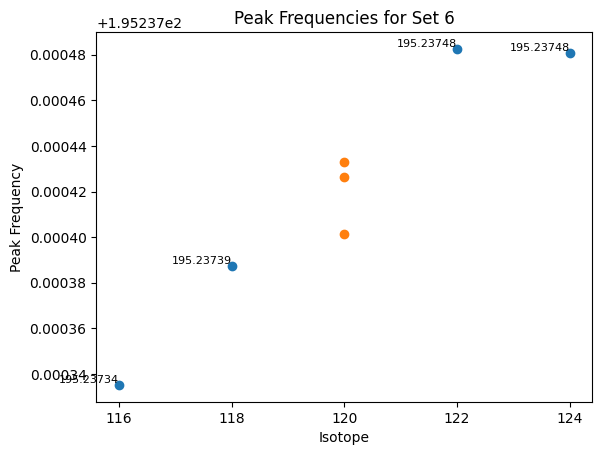

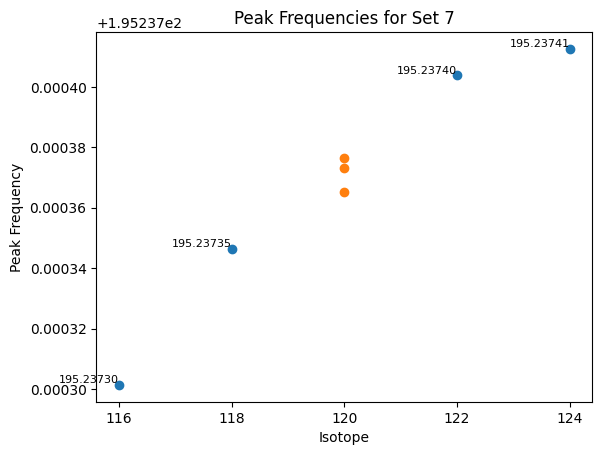

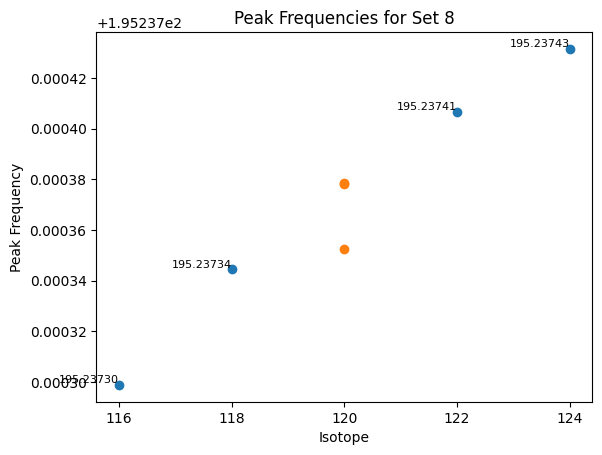

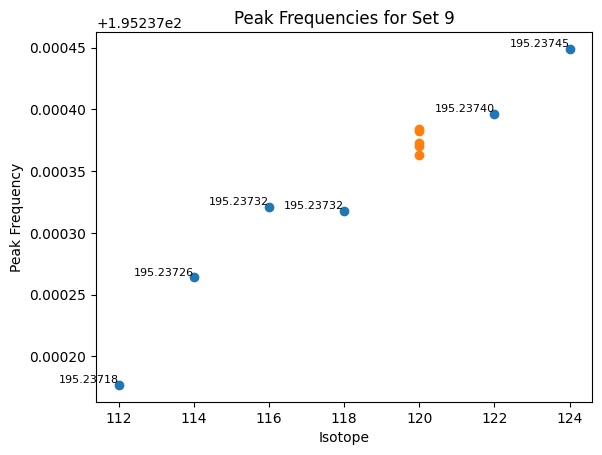

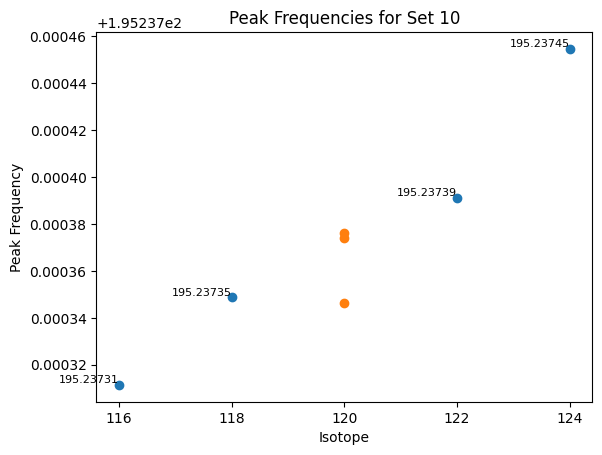

In [ ]:
# Iterate through each set in the data
for set_number, set_data in results.items():
    # Get the isotopes and their corresponding peaks
    isotopes = set_data['isotopes']
    peaks = set_data['peaks']
    peaks_120 = sn120[set_number]['peaks_120']
    
    # Flatten the peaks list for plotting
    flat_peaks = [peak for sublist in peaks for peak in sublist]
    flat_isotopes = [isotope for isotope, peak_list in zip(isotopes, peaks) for _ in peak_list]
    
    plt.figure()
    plt.scatter(flat_isotopes, flat_peaks)
    plt.scatter([120] * len(peaks_120), peaks_120)

    for isotope, peak_list in zip(isotopes, peaks):
        for peak in peak_list:
            plt.text(isotope, peak, f'{peak:.5f}', fontsize=8, ha='right', va='bottom')
    
    all_isotopes = list(set(isotopes + [120]))  # Combine isotopes and add 120
    plt.xticks(all_isotopes, all_isotopes)
    plt.title(f'Peak Frequencies for Set {set_number}')
    plt.xlabel('Isotope')
    plt.ylabel('Peak Frequency')
    plt.show()
plt.show()

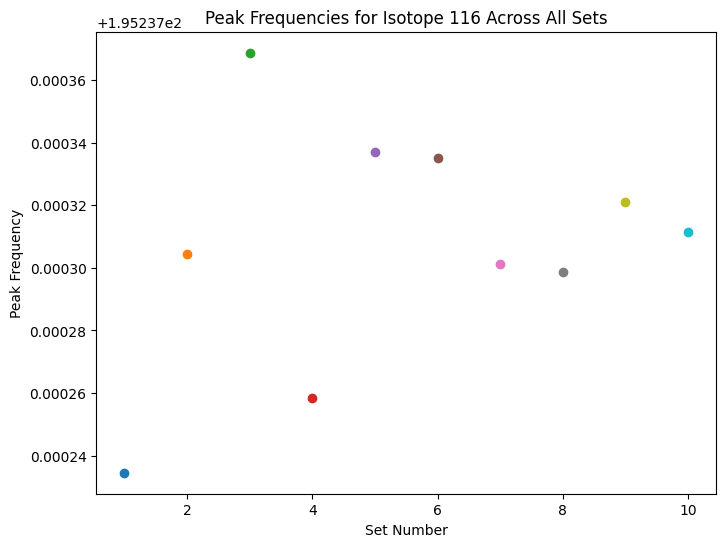

Average peak frequency for isotope 116: 195.237307(36)
195.23730710626734 3.664300983031043e-05


In [677]:
isotope_to_plot = 116

# Create a new figure for plotting
plt.figure(figsize=(8, 6))
all_peaks = []

# Iterate through each set in the data and collect peaks for the chosen isotope
for set_number, set_data in results.items():
    # Get the isotopes and their corresponding peaks
    isotopes = set_data['isotopes']
    peaks = set_data['peaks']
    
    # Check if the chosen isotope is in the current set
    if isotope_to_plot in isotopes:
        # Find the index of the chosen isotope
        isotope_index = isotopes.index(isotope_to_plot)
        all_peaks.extend(peaks[isotope_index])
        
        # Plot the peaks for this isotope in the current set
        plt.scatter([set_number] * len(peaks[isotope_index]), peaks[isotope_index], label=f'Set {set_number}')

# Set plot labels and title
plt.title(f'Peak Frequencies for Isotope {isotope_to_plot} Across All Sets')
plt.xlabel('Set Number')
plt.ylabel('Peak Frequency')
plt.show()

average_peak = np.mean(all_peaks)
stddev_peak = np.std(all_peaks)

# Format the output as mean(stddev) with 5 decimal places for mean and 2 for stddev
formatted_result = f"{average_peak:.6f}({int(stddev_peak * 1e6):02d})"
print(f"Average peak frequency for isotope {isotope_to_plot}: {formatted_result}")
print(average_peak,stddev_peak)
